In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time, sys, os
from concurrent.futures import ProcessPoolExecutor, as_completed

directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.rcParams['figure.dpi']=400

In [2]:
def denseH_MBL(L, J, hx_list, hz_list, periodic):
    """
    Generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            hx (ndarray): array of transverse field strengths
            hz (ndarray): array of longitudinal field strengths
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim), dtype = float) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx_list[j-1] # contribution by sigma^j_x
            
            
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz_list[j-1]  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz_list[j-1]  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   





In [3]:
def diagonalize_MBL(Ls, J, hx_list, hz_list, periodic):
    eigss = []
    vecss = []
    
    for i, L in enumerate(Ls):
        hx = hx_list[i]
        hz = hz_list[i]
        H = denseH_MBL(L, J, hx, hz, periodic)
        eigs, vecs = scipy.linalg.eigh(H)
        eigss.append(eigs)
        vecss.append(vecs)
    
    return eigss, vecss


In [4]:
def mps(psi, k):

    # Converts a wavefunction into mps form
    
    mps_tensors = []
    L = int(np.log2(len(psi)))  # Number of spins/sites
    psi_matrix = psi.reshape(2, 2**(L-1))

    for i in range(L-1):
        
        U, S, Vh = np.linalg.svd(psi_matrix, full_matrices=False)
        
        chi = min(k, len(S))
        
        S_truncated = S[: chi]
        U_truncated = U[:, :chi]
        Vh_truncated = Vh[:chi, :]

        mps_tensors.append(U_truncated.reshape((-1, 2, chi)))

        if i < L - 2:
            psi_matrix = (np.diag(S_truncated) @ Vh_truncated).reshape(2*chi, -1)
            
        else:
            last_tensor = (np.diag(S_truncated) @ Vh_truncated)
            mps_tensors.append(last_tensor.reshape(chi, 2, -1))

    return mps_tensors

def contract_mps_tensors(mps_tensors):

    # converts mps tensor form to a usual column vector wave-function.
    
    state = mps_tensors[0]
    
    for tensor in mps_tensors[1:]: 
        state = np.einsum('ijk,kln->ijln', state, tensor).reshape(1, -1, tensor.shape[2])
        
    return state.reshape(-1)

def inner_product(bra, ket):

    # function to output <psi|psi> when given in MPS form 
    
    result = np.einsum('jkl,mkn->ln', bra[0].conj(), ket[0])
    
    for i in range(1, len(ket)):

        A = np.einsum('jkl,mkn->jmln', bra[i].conj(), ket[i])
        result = np.einsum('jm,jmln->ln', result, A)
    
    return result.reshape(-1)[0]

def magnetic_term(ket, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(L):
        
        Hket = [np.copy(k) for k in ket]
    
        Hket[i] = hx*np.einsum('ij,kjm->kim', X, ket[i]) + hz*np.einsum('ij,kjm->kim', Z, ket[i])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)
        

def ising_term(ket):
    
    Z = np.array([[1,0],[0,-1]])
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(0, L-1):
        
        Hket = [np.copy(k) for k in ket]
        
        Hket[i] = np.einsum('ij,kjm->kim', Z, ket[i])
        
        Hket[i+1] = np.einsum('ij,kjm->kim', Z, ket[i+1])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)

def expectation_value_energy(ket, hx, hz, J):
    
    energy = -magnetic_term(ket, hx, hz)-J*ising_term(ket)
    norm = inner_product(ket, ket)
    
    return energy/norm

In [5]:
def local_gate(dt, hx_list, hz_list, ket):
    '''
        Applies the local trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    ket_new = []
    
    for i in range(L):
        w = np.array([[-hz_list[i], -hx_list[i]], [-hx_list[i], hz_list[i]]])
        R = scipy.linalg.expm(-1j*dt*w)
        ket_new.append(np.einsum('ij,kjm->kim', R, ket[i]))

    return ket_new

def twosite_even_gate(dt, J, ket):
    '''
        Applies the even trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0],[0, -1]])
    H = 1j * dt * J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    
    for i in range(0, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))

    if L%2 != 0:
        ket_new.append(ket[L-1])
        
        
    return ket_new

def twosite_odd_gate(dt, J, ket):
    '''
        Applies the odd trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0], [0, -1]])
    H = 1j * dt* J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    ket_new.append(ket[0])
    
    for i in range(1, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))
    
    if L%2 == 0:
        ket_new.append(ket[L-1])
        
    return ket_new

def canonical_converter(mps_tensors):
    '''
        Converts the tensor into canonical form with the orthogonality center at L
    '''
    new_mps_tensors = mps_tensors.copy()
    L = len(new_mps_tensors)

    for i in range(L-1):
        W = np.einsum('ijk,klm->ijlm', new_mps_tensors[i], new_mps_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = len(S)

        U = U[:, :chi]
        new_mps_tensors[i] = U.reshape(-1, 2, chi)
        
        S = np.diag(S[:chi])
        Vh = Vh[:chi, :]

        new_mps_tensors[i+1] = (S @ Vh).reshape(chi, 2, -1)

    return new_mps_tensors

def bond_dimension_conserver(k, canonical_mps):
    '''
        given a canonical MPS it goes from left to right truncating the schmidt values to k at each step
        it stores U, S, Vh at every cut to help speed up calculations
        returns the values at the cuts from right to left
    '''
    truncated_mps = canonical_mps.copy()
    L = len(canonical_mps)
    canonical_tracker=[]
    canonical_tracker2 = []
    
    for i in range(L-1, 0, -1):
                
        W = np.einsum('ijk,klm->ijlm', truncated_mps[i-1], truncated_mps[i])

        Wmatrix = W.reshape((W.shape[0]*2, -1))
        
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        
        truncated_mps[i] = Vh.reshape(chi, 2, -1)
        
        truncated_mps[i-1] = (U @ np.diag(S[:chi])).reshape(-1, 2, chi)

    canonical_tensors = truncated_mps.copy()
    for i in range(L-1):

        W = np.einsum('ijk,klm->ijlm', canonical_tensors[i], canonical_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        canonical_tracker.append([U.reshape(-1, 2, chi), S[:chi], Vh.reshape(chi, 2, -1)])
        canonical_tensors[i+1] = (np.diag(S[:chi])@Vh).reshape(chi, 2, -1)


    return truncated_mps, canonical_tracker


def magnetic_term_canonical(canonical_tracker, hx_list, hz_list):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])

    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Ssq = np.einsum('ij,kj->ik', S.conj(), S)
        # apply X,Z to U
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        # apply S^2 to U
        ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
        XUS = np.einsum('kim,nm->kin', XU, Ssq)
        
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

        results[i] = -hz_list[i]*np.einsum('aabb', UhZUS) - hx_list[i]*np.einsum('aabb', UhXUS)

    Ssq = np.einsum('ij,ik->jk', S.conj(), S)
    Vh = canonical_tracker[L-2][2]
    
    ZVh = np.einsum('ij,kjm->kim', Z, Vh)
    XVh = np.einsum('ij,kjm->kim', X, Vh)
    
    ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
    XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
    
    VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
    VXVhS = np.einsum('aib,kin->akbn', Vh.conj(), XVhS)

    results[L-1] = -hz_list[L-1]*np.einsum('aabb', VZVhS) - hx_list[L-1]*np.einsum('aabb', VXVhS)
    
    return np.sum(results)/np.sum(Ssq)

def ising_term_canonical(canonical_tracker, J):
    Z = np.array([[1,0],[0,-1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Vh = canonical_tracker[i][2]

        Uh = U.conj()
        V = Vh.conj()

        US = np.einsum('abc,cd->abd', U, S)
        USVh = np.einsum('abd,def->abef', US, Vh)
        UhS = np.einsum('abc,cd->abd', Uh, S)
        UhSV = np.einsum('abd,def->abef', UhS, V)
        
        ZUSVh = np.einsum('ib,abef->aief', Z, USVh)
        ZUSVhZ = np.einsum('je,aief->aijf', Z, ZUSVh)

        UhSV_ZUSVhZ = np.einsum('abcd,ebcf->aedf', UhSV, ZUSVhZ)

        results[i] = -J*np.einsum('aabb', UhSV_ZUSVhZ)

    return np.sum(results)/np.sum(S**2)
        
def expectation_value_energy_canonical(canonical_tracker, hx, hz, J):
    
    return magnetic_term_canonical(canonical_tracker, hx, hz) + ising_term_canonical(canonical_tracker, J)

In [6]:
def trotter_step(dt, J, hx_list, hz_list, ket, k):
    
    evolved_ket = canonical_converter(
        twosite_odd_gate(
            dt, J,
            twosite_even_gate(
                dt, J,
                local_gate(dt, hx_list, hz_list, ket.copy())
            )
        )
    )


    return bond_dimension_conserver(k, evolved_ket)
def time_evolution(T, J, hx_list, hz_list, ket, k, iters):
    dt = T / iters
    
    ket_initial, canonical_tracker = bond_dimension_conserver(k, ket)
    evolved_ket = ket.copy()
    canonical_trackers = [canonical_tracker]
   
    for i in range(iters):
        evolved_ket, canonical_tracker = trotter_step(dt, J, hx_list, hz_list, evolved_ket, k)
        canonical_trackers.append(canonical_tracker)

    return evolved_ket, canonical_trackers

In [7]:
def psi_initial_mps(L):
    
    mps_tensors= []
    
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1/2
    A[0, 1, 0] = -np.sqrt(3)/2
    
    for i in range(L):
        mps_tensors.append(A)

    return mps_tensors

In [8]:
import logging
from joblib import Parallel, delayed

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def perform_evolution(index):
    L = 64
    W = 5
    t = 10
    J = 1
    dt = 0.01
    chi = 16
    hx_list = np.random.uniform(-W, W, L)
    hz_list = np.random.uniform(-W, W, L)
    logging.info(f"Worker {index} started.")  # Use logging instead of print
    ket = psi_initial_mps(L)
    result = time_evolution(t, J, hx_list, hz_list, ket, chi, int(t/dt))
    return result

start_time = time.time()

results = Parallel(n_jobs=-2)(
    delayed(perform_evolution)(i) for i in range(20)
)

end_time = time.time()
total_time = end_time - start_time

logging.info("Total time taken: {:.2f} seconds".format(total_time))


2024-06-05 04:47:15,093 - INFO - Total time taken: 1992.49 seconds


In [12]:
evolved_kets = []
canonical_trackerss = []

for i in range(20):
    evolved_kets.append(results[i][0])
    canonical_trackerss.append(results[i][1])

In [ ]:
def expectation_value_Cz(r, canonical_tracker):

    Z = np.array([[1, 0], [0, -1]])
    # r neq L
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    ZU = np.einsum('ij,kjm->kim', Z, U)
    ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
    UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
    
    return np.einsum('aabb', UhZUS)/(np.sum(Ssq))

In [10]:
import pickle  # Import the pickle module

def save_results(results, filename="evolution_results.pkl"):
    """ Save the computation results to a pickle file. """
    with open(filename, "wb") as f:
        pickle.dump(results, f)

save_results(results)
print('done')


KeyboardInterrupt



In [15]:
def entanglement_entropy(l, canonical_tracker):
    s = canonical_tracker[l][1]
    
    lambdas = s**2
    lambdas = lambdas/np.sum(lambdas)
    S = -np.sum(lambdas * np.log(lambdas))
    return S

In [16]:
L = 64
W = 5
t = 10
J = 1
dt = 0.01
chi = 16

Computing Entropies:   0%|                                                                    | 0/1001 [00:00<?, ?it/s]C:\Users\cheru\AppData\Local\Temp\ipykernel_25160\2574989919.py:6: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(lambdas * np.log(lambdas))
C:\Users\cheru\AppData\Local\Temp\ipykernel_25160\2574989919.py:6: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(lambdas * np.log(lambdas))
Computing Entropies: 100%|████████████████████████████████████████████████████████| 1001/1001 [00:05<00:00, 167.56it/s]
2024-06-05 06:13:35,254 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


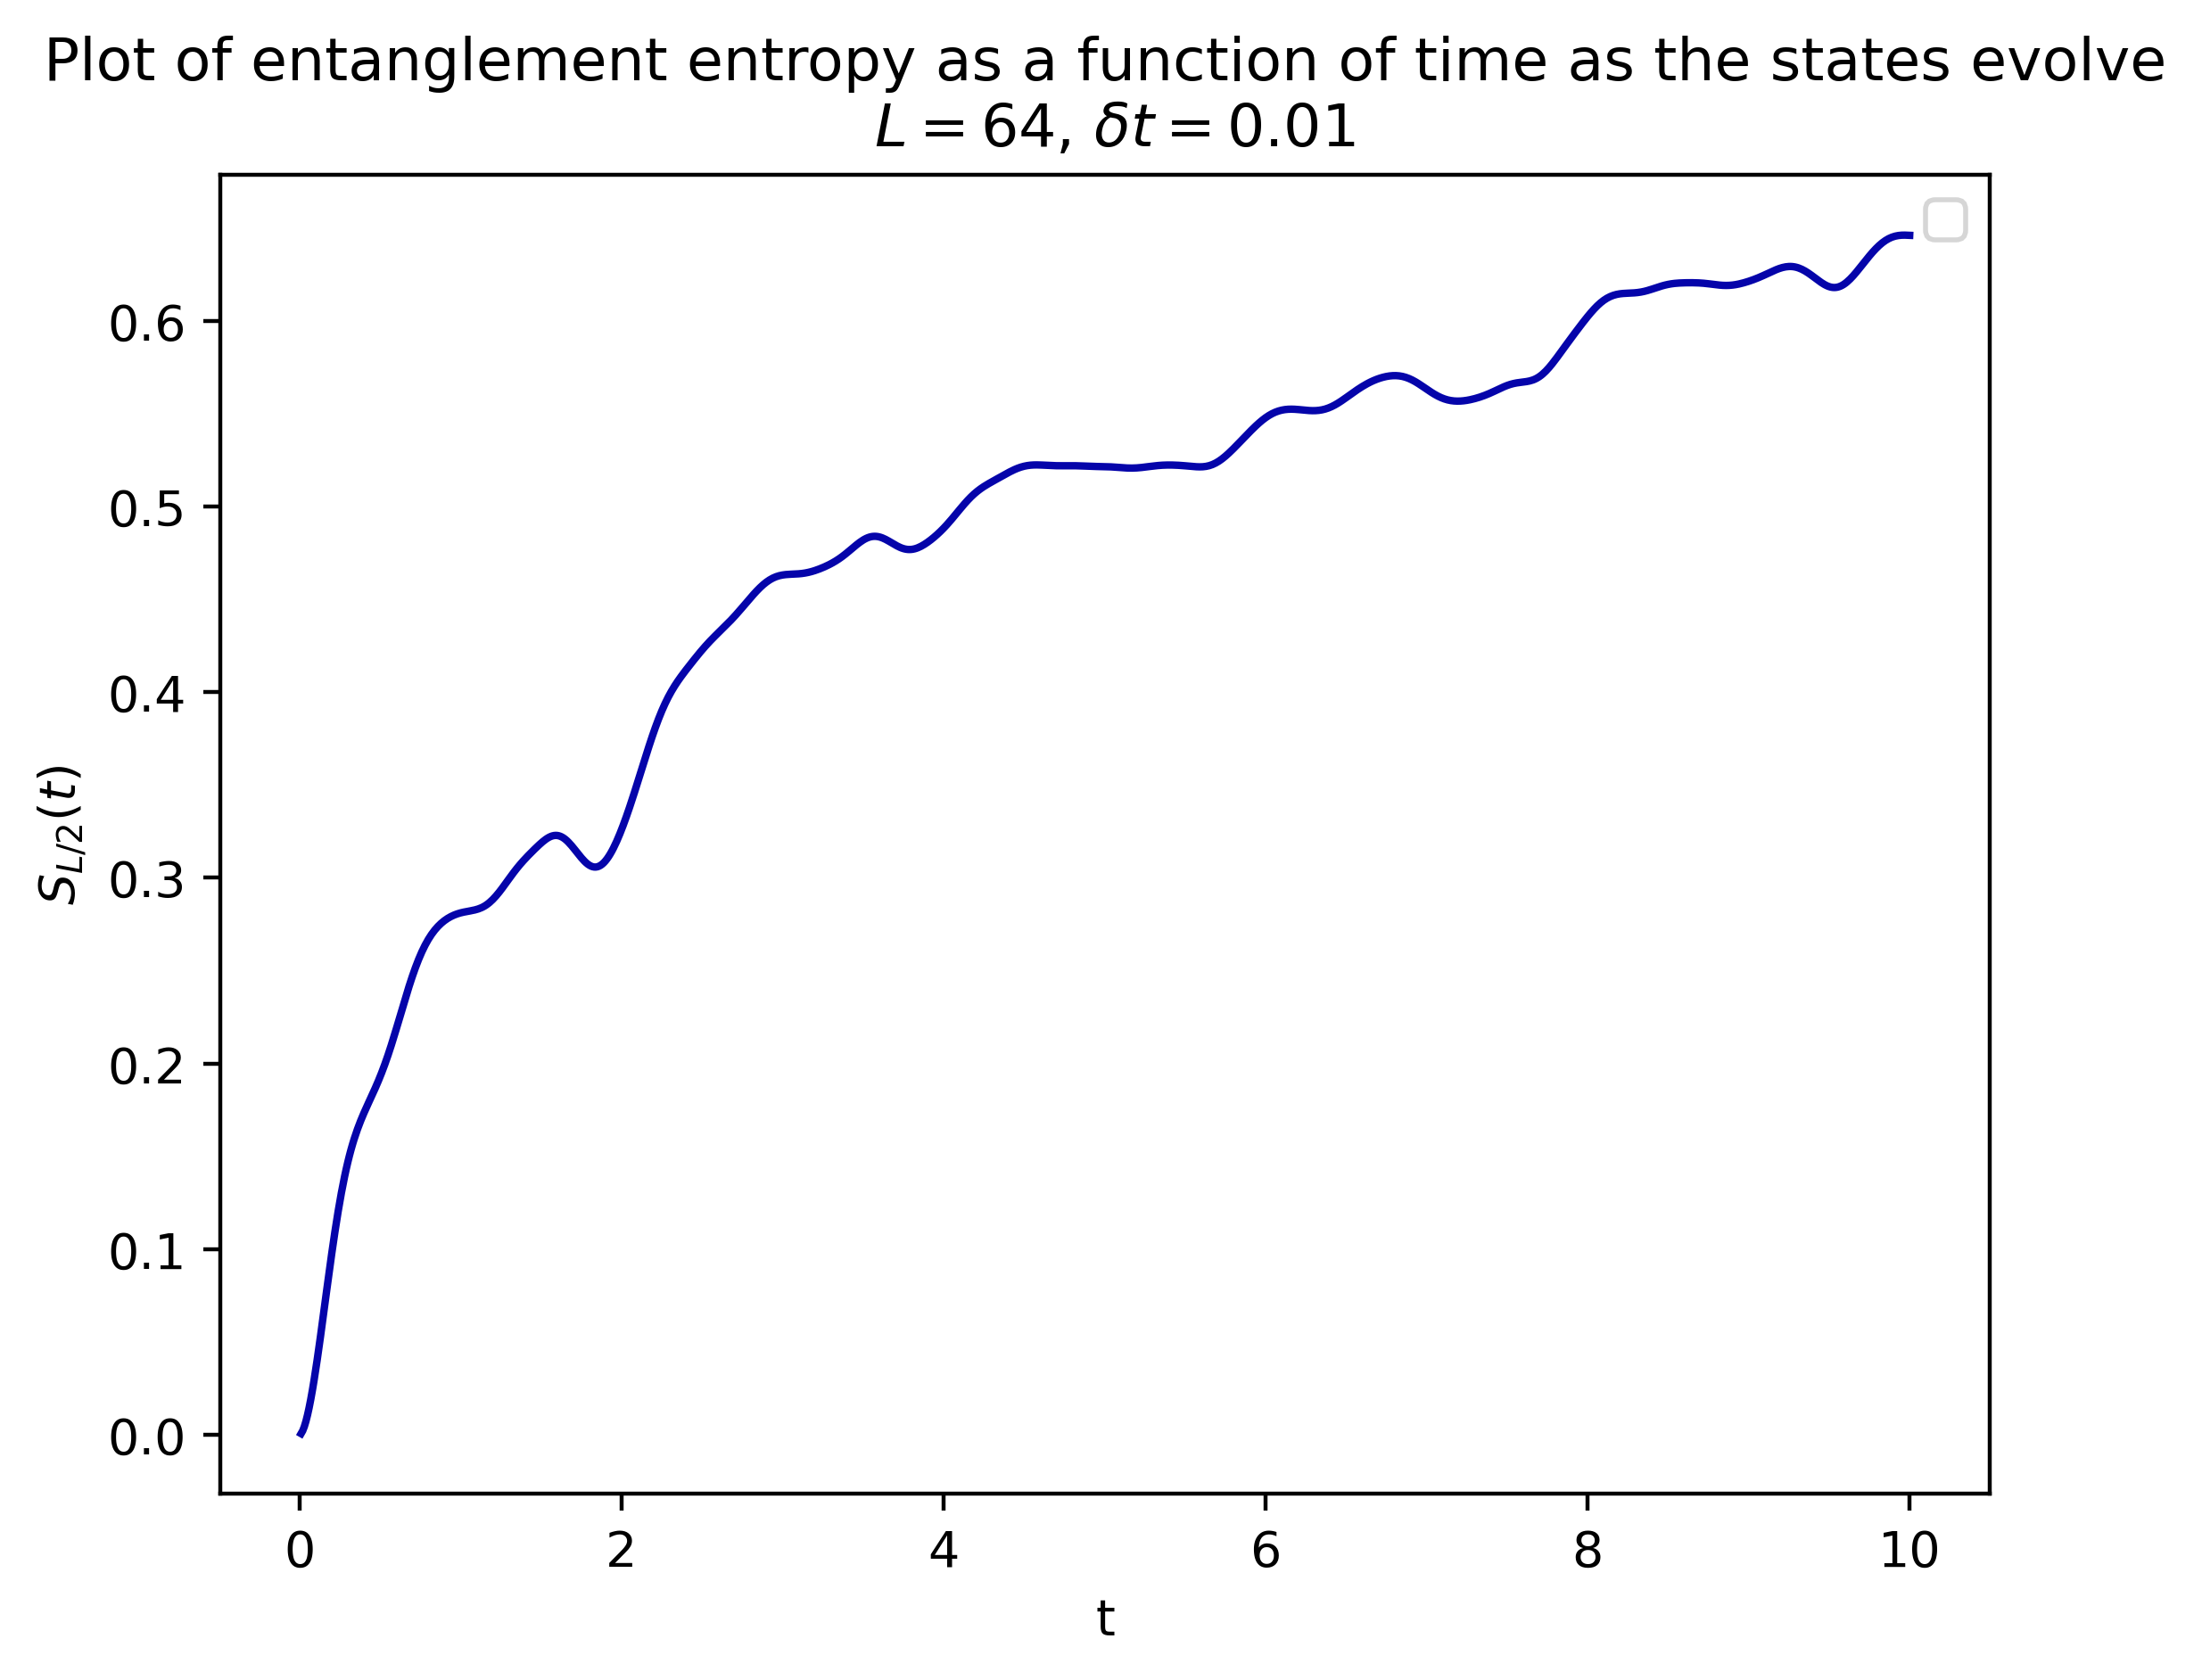

In [17]:
entropies = []

for i in tqdm(range(len(canonical_trackerss[0])), desc="Computing Entropies"):
    entropies_realizations = []
    for j in range(20):
        entropy = entanglement_entropy(L//2, canonical_trackerss[j][i])
        entropies_realizations.append(entropy)
    
    entropies.append(np.mean(entropies_realizations))


plt.plot(np.arange(0, len(canonical_trackerss[0]), 1)*dt, entropies, color='xkcd:royal blue')    


plt.title('Plot of entanglement entropy as a function of time as the states evolve'+'\n $L = 64$, $\delta t = 0.01$')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig(os.path.join(directory, 'entropyp3.png'), dpi=400)


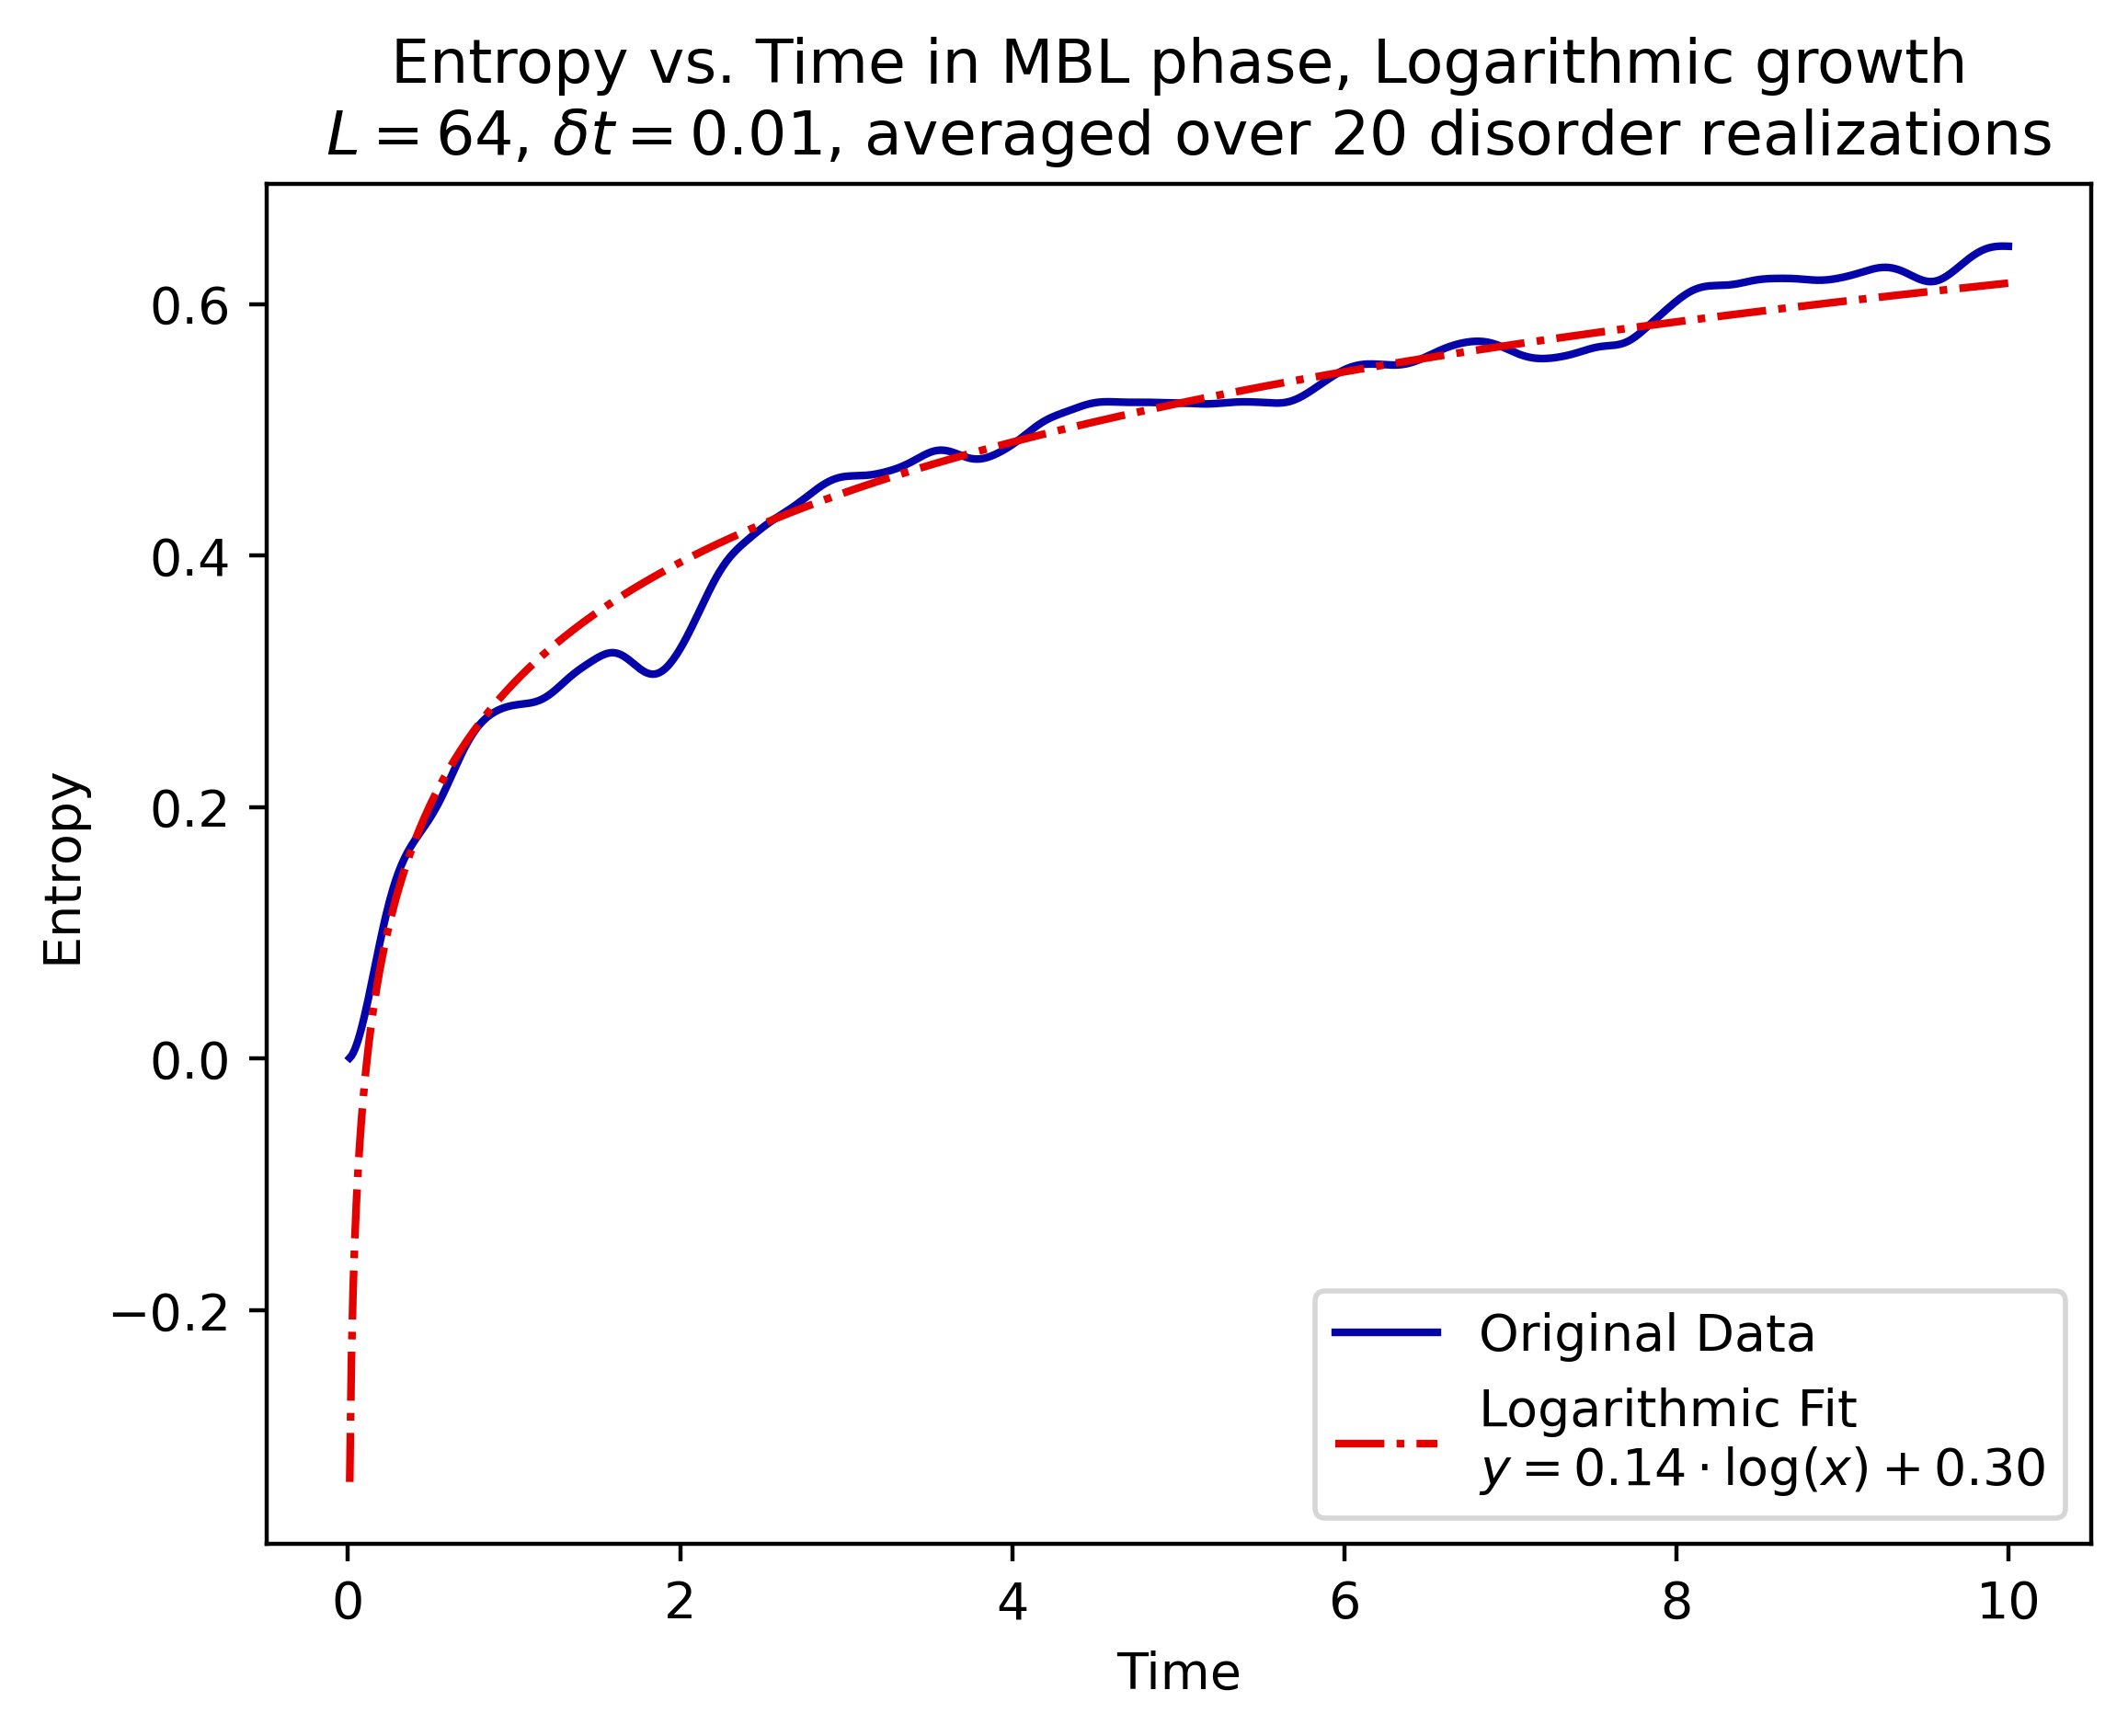

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

x_values = np.arange(0, len(entropies)) * dt
y_values = np.array(entropies)

non_zero_indices = x_values > 0
x_values = x_values[non_zero_indices]
y_values = y_values[non_zero_indices]

log_x_values = np.log(x_values).reshape(-1, 1)

model = LinearRegression().fit(log_x_values, y_values)


a = model.coef_[0]  # Slope
b = model.intercept_  # Intercept

fitted_y_values = model.predict(log_x_values)

plt.plot(x_values, y_values, color='xkcd:royal blue', label='Original Data')
plt.plot(x_values, fitted_y_values, color='xkcd:red', label='Logarithmic Fit'+f'\n$y = {a:.2f} \cdot \log(x) + {b:.2f}$', linestyle = 'dashdot')

# plt.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
#              bbox=dict(boxstyle="round", fc="white", ec="black"))

plt.xlabel('Time')
plt.ylabel('Entropy')
plt.title('Entropy vs. Time in MBL phase, Logarithmic growth'+'\n $L = 64$, $\delta t = 0.01$, averaged over 20 disorder realizations')
plt.legend()
plt.savefig(os.path.join(directory, 'entropyp3main.png'), dpi=400)
plt.show()


In [41]:
def expectation_value_Cz(r, canonical_tracker):

    Z = np.array([[1, 0], [0, -1]])
    # r neq L
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    ZU = np.einsum('ij,kjm->kim', Z, U)
    ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
    UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
    
    return np.einsum('aabb', UhZUS)/(np.sum(Ssq))

def expectation_value_Cx(r, canonical_tracker):
    
    X = np.array([[0, 1], [1, 0]])
    # r neq L
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    XU = np.einsum('ij,kjm->kim', X, U)
    XUS = np.einsum('kim,nm->kin', XU, Ssq)
    UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

    return np.einsum('aabb', UhXUS)/(np.sum(Ssq))
    

Computing Entropies: 100%|████████████████████████████████████████████████████████| 1001/1001 [00:04<00:00, 210.72it/s]
C:\Users\cheru\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\cheru\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
2024-06-05 06:30:44,791 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


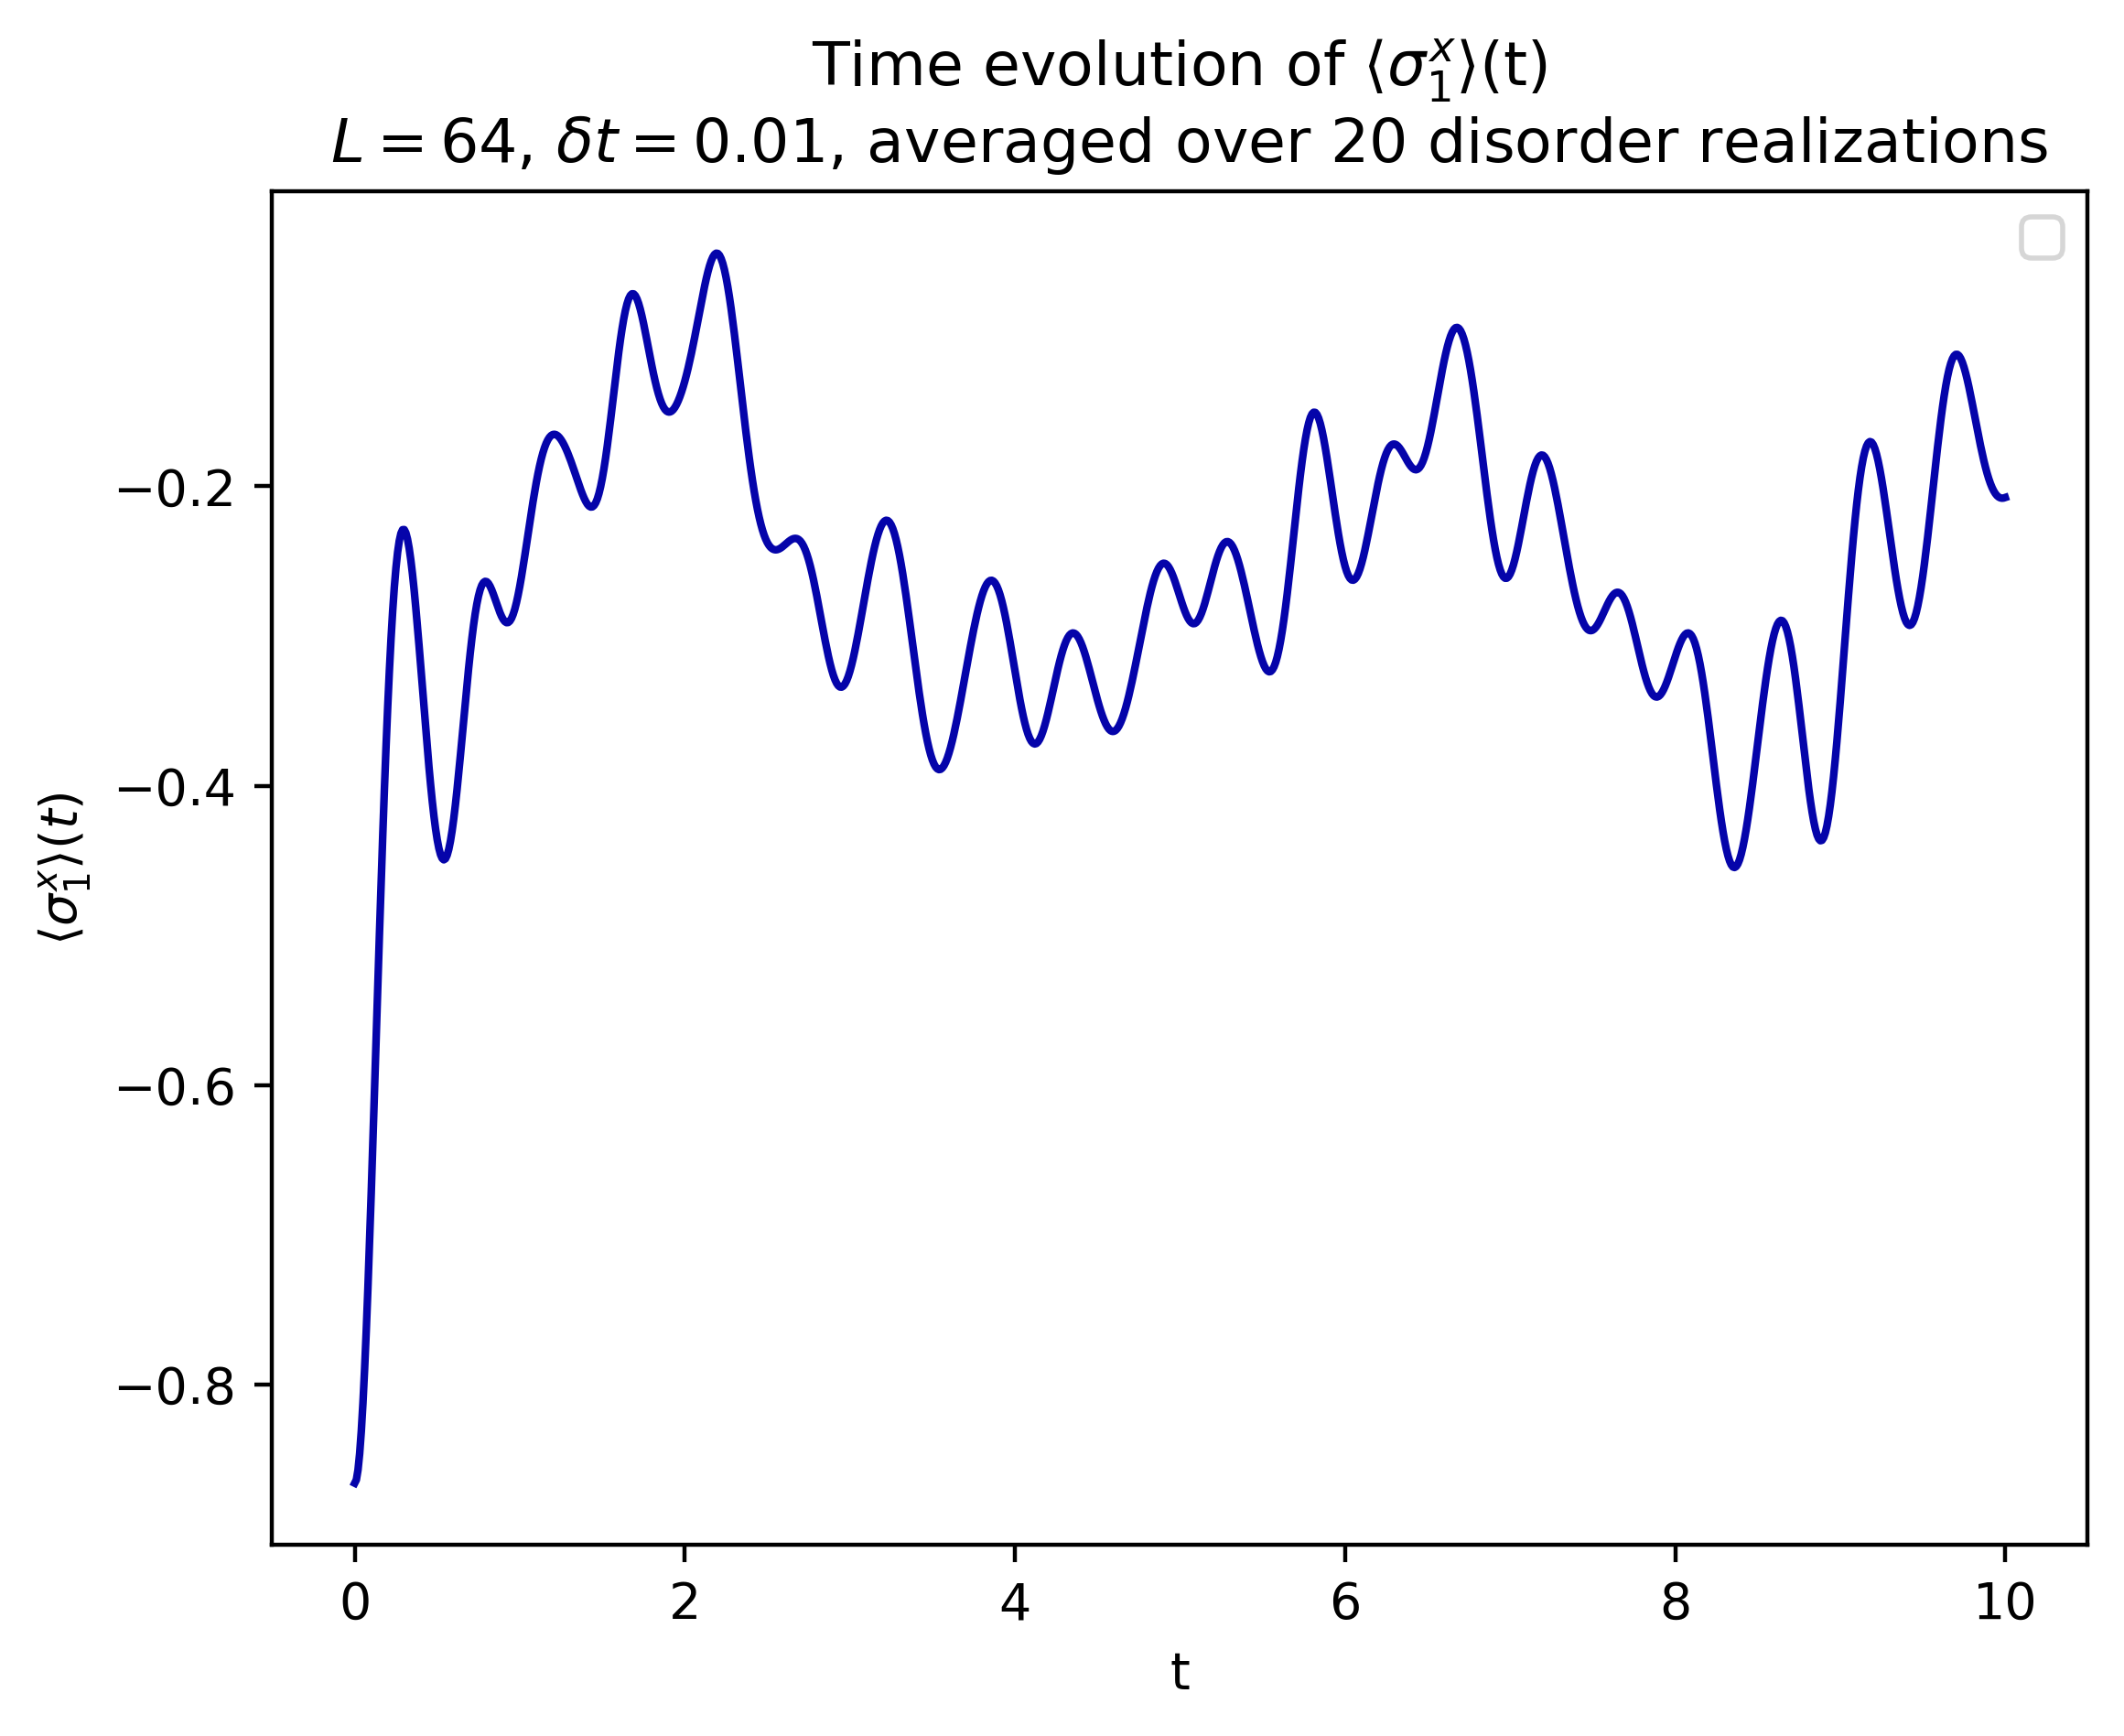

In [43]:
observables = []

for i in tqdm(range(len(canonical_trackerss[0])), desc="Computing Observables"):
    observable_realizations = []
    for j in range(20):
        observable = expectation_value_Cx(1, canonical_trackerss[j][i])
        observable_realizations.append(observable)
    
    observables.append(np.mean(observable_realizations))


plt.plot(np.arange(0, len(canonical_trackerss[0]), 1)*dt, observables, color='xkcd:royal blue')  

         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{1}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{1}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$, averaged over 20 disorder realizations')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxp3.png'), dpi=400)
plt.show()

Computing Observables: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:47<00:00, 21.18it/s]
2024-06-05 06:32:34,261 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


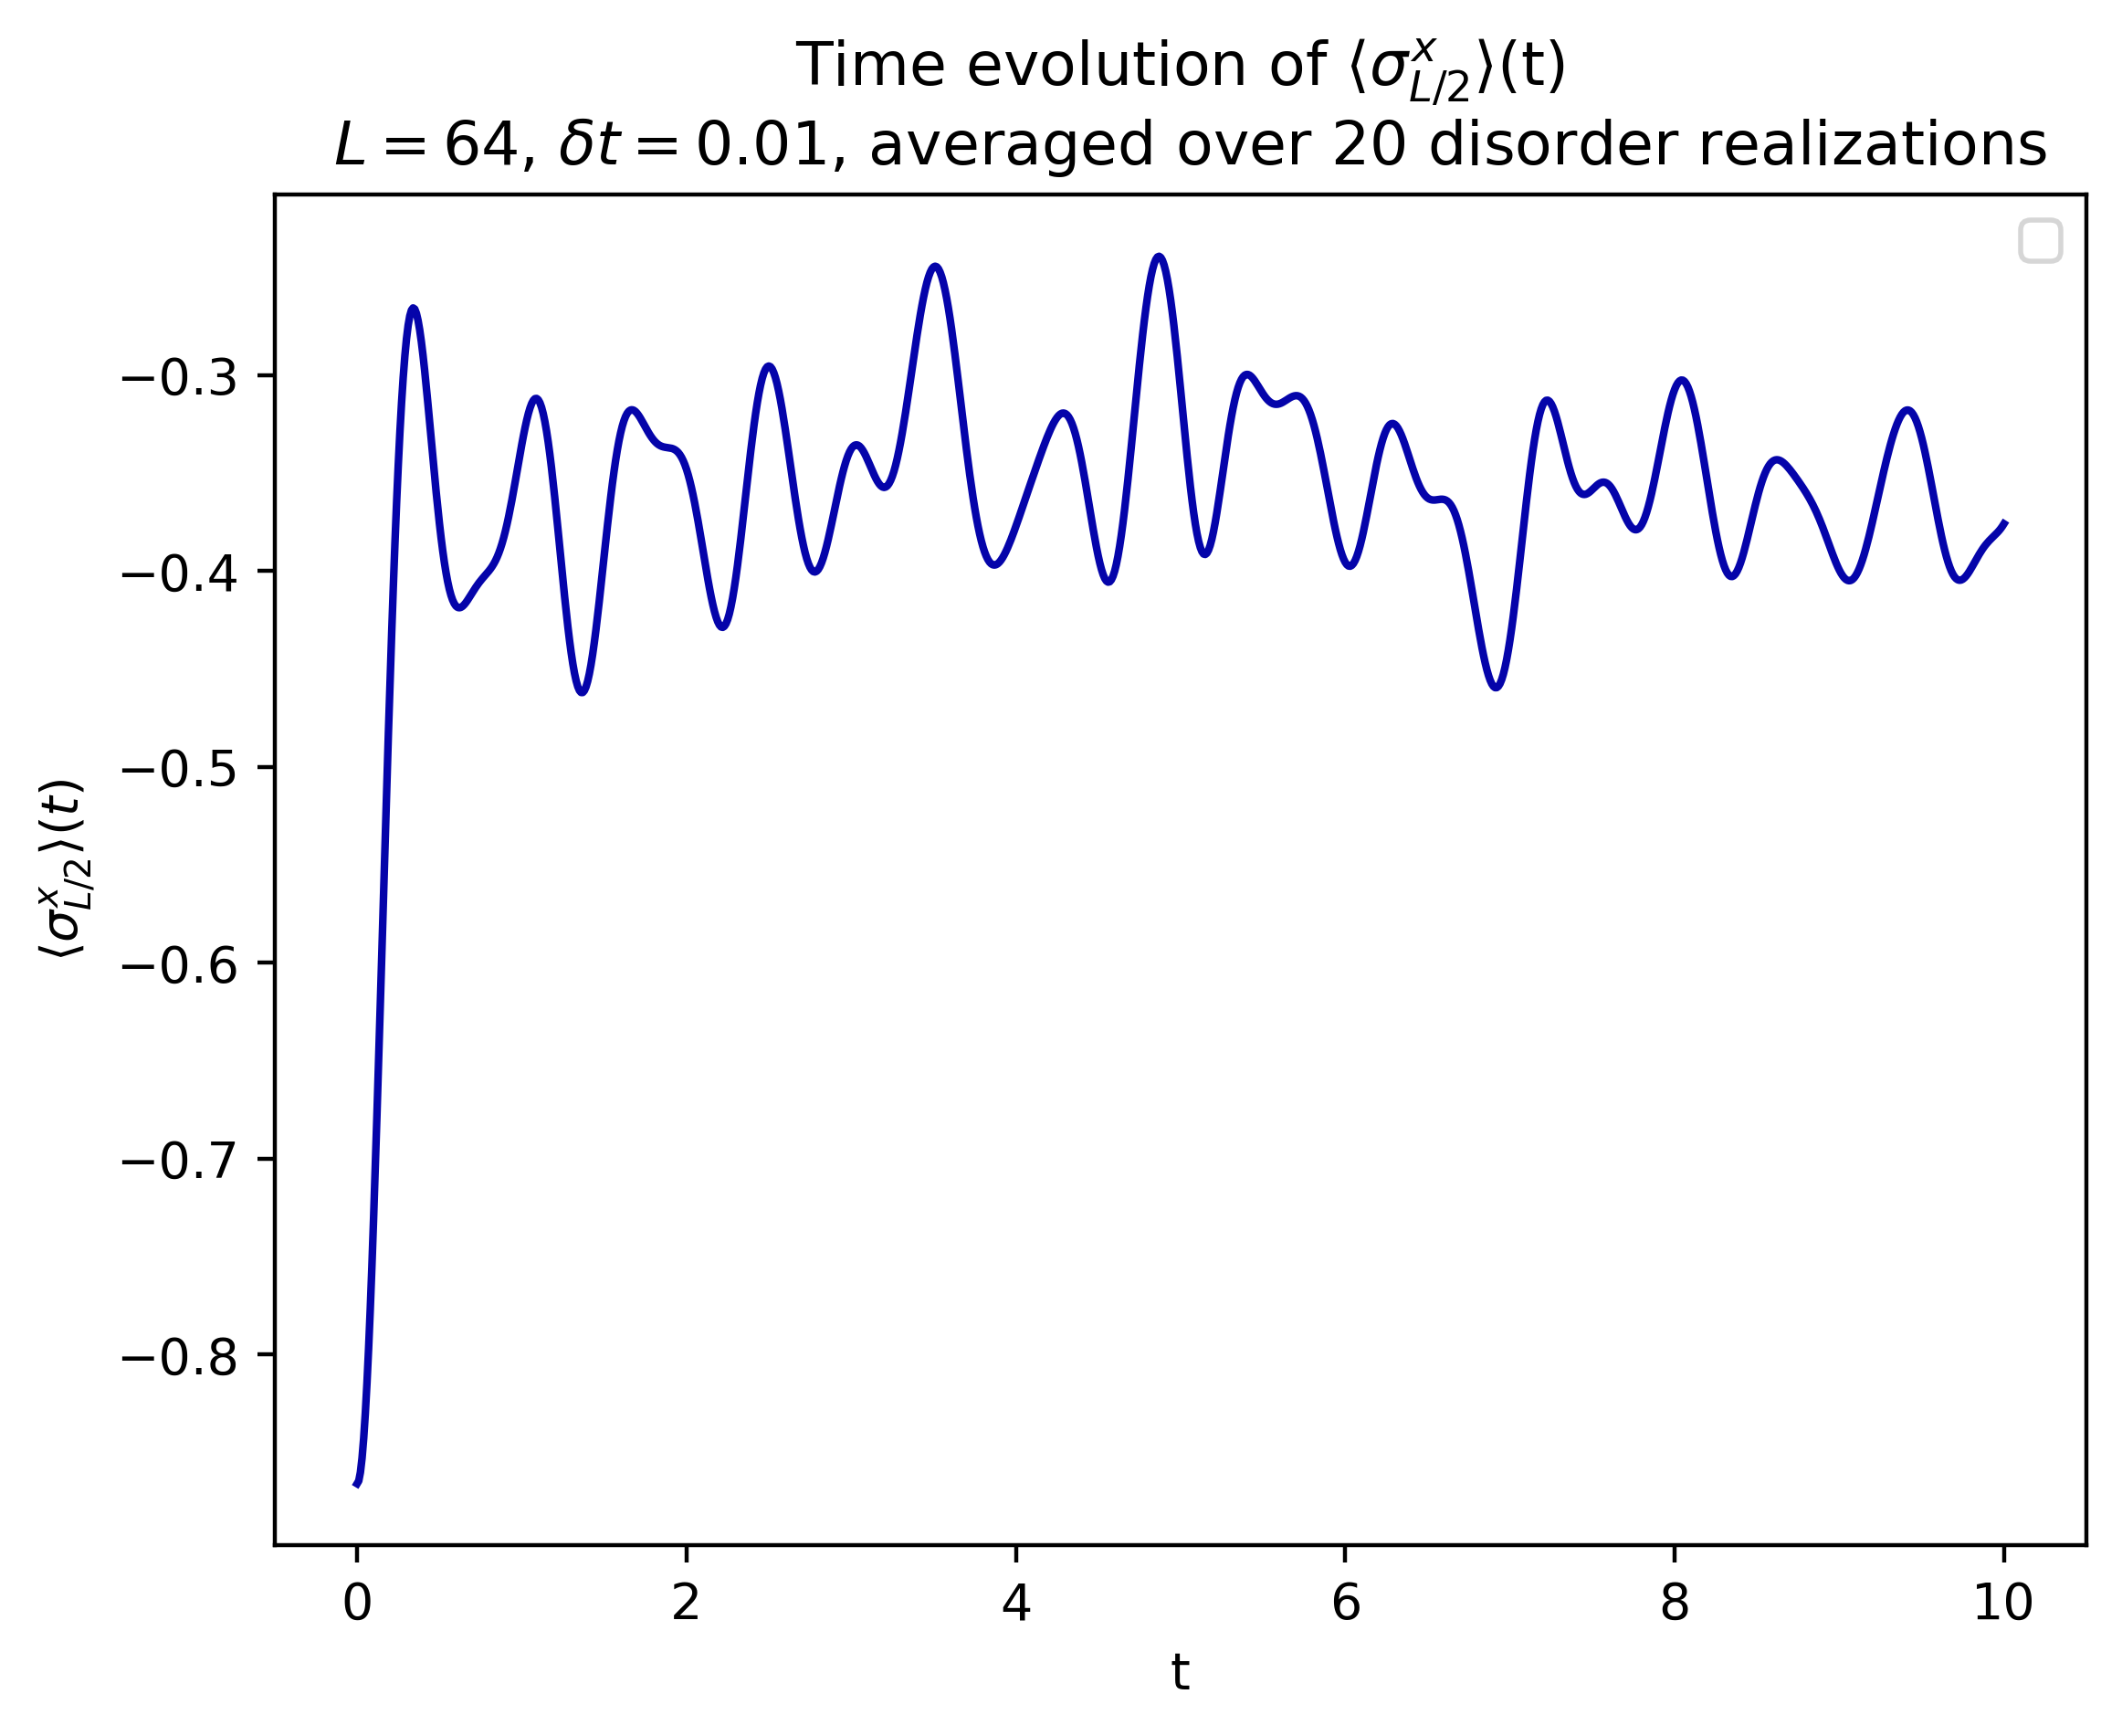

In [44]:
observables = []

for i in tqdm(range(len(canonical_trackerss[0])), desc="Computing Observables"):
    observable_realizations = []
    for j in range(20):
        observable = expectation_value_Cx(L//2, canonical_trackerss[j][i])
        observable_realizations.append(observable)
    
    observables.append(np.mean(observable_realizations))


plt.plot(np.arange(0, len(canonical_trackerss[0]), 1)*dt, observables, color='xkcd:royal blue')  

         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{L/2}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$, averaged over 20 disorder realizations')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxp3middle.png'), dpi=400)
plt.show()

Computing Observables: 100%|█████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 1165.10it/s]
2024-06-05 06:32:47,168 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


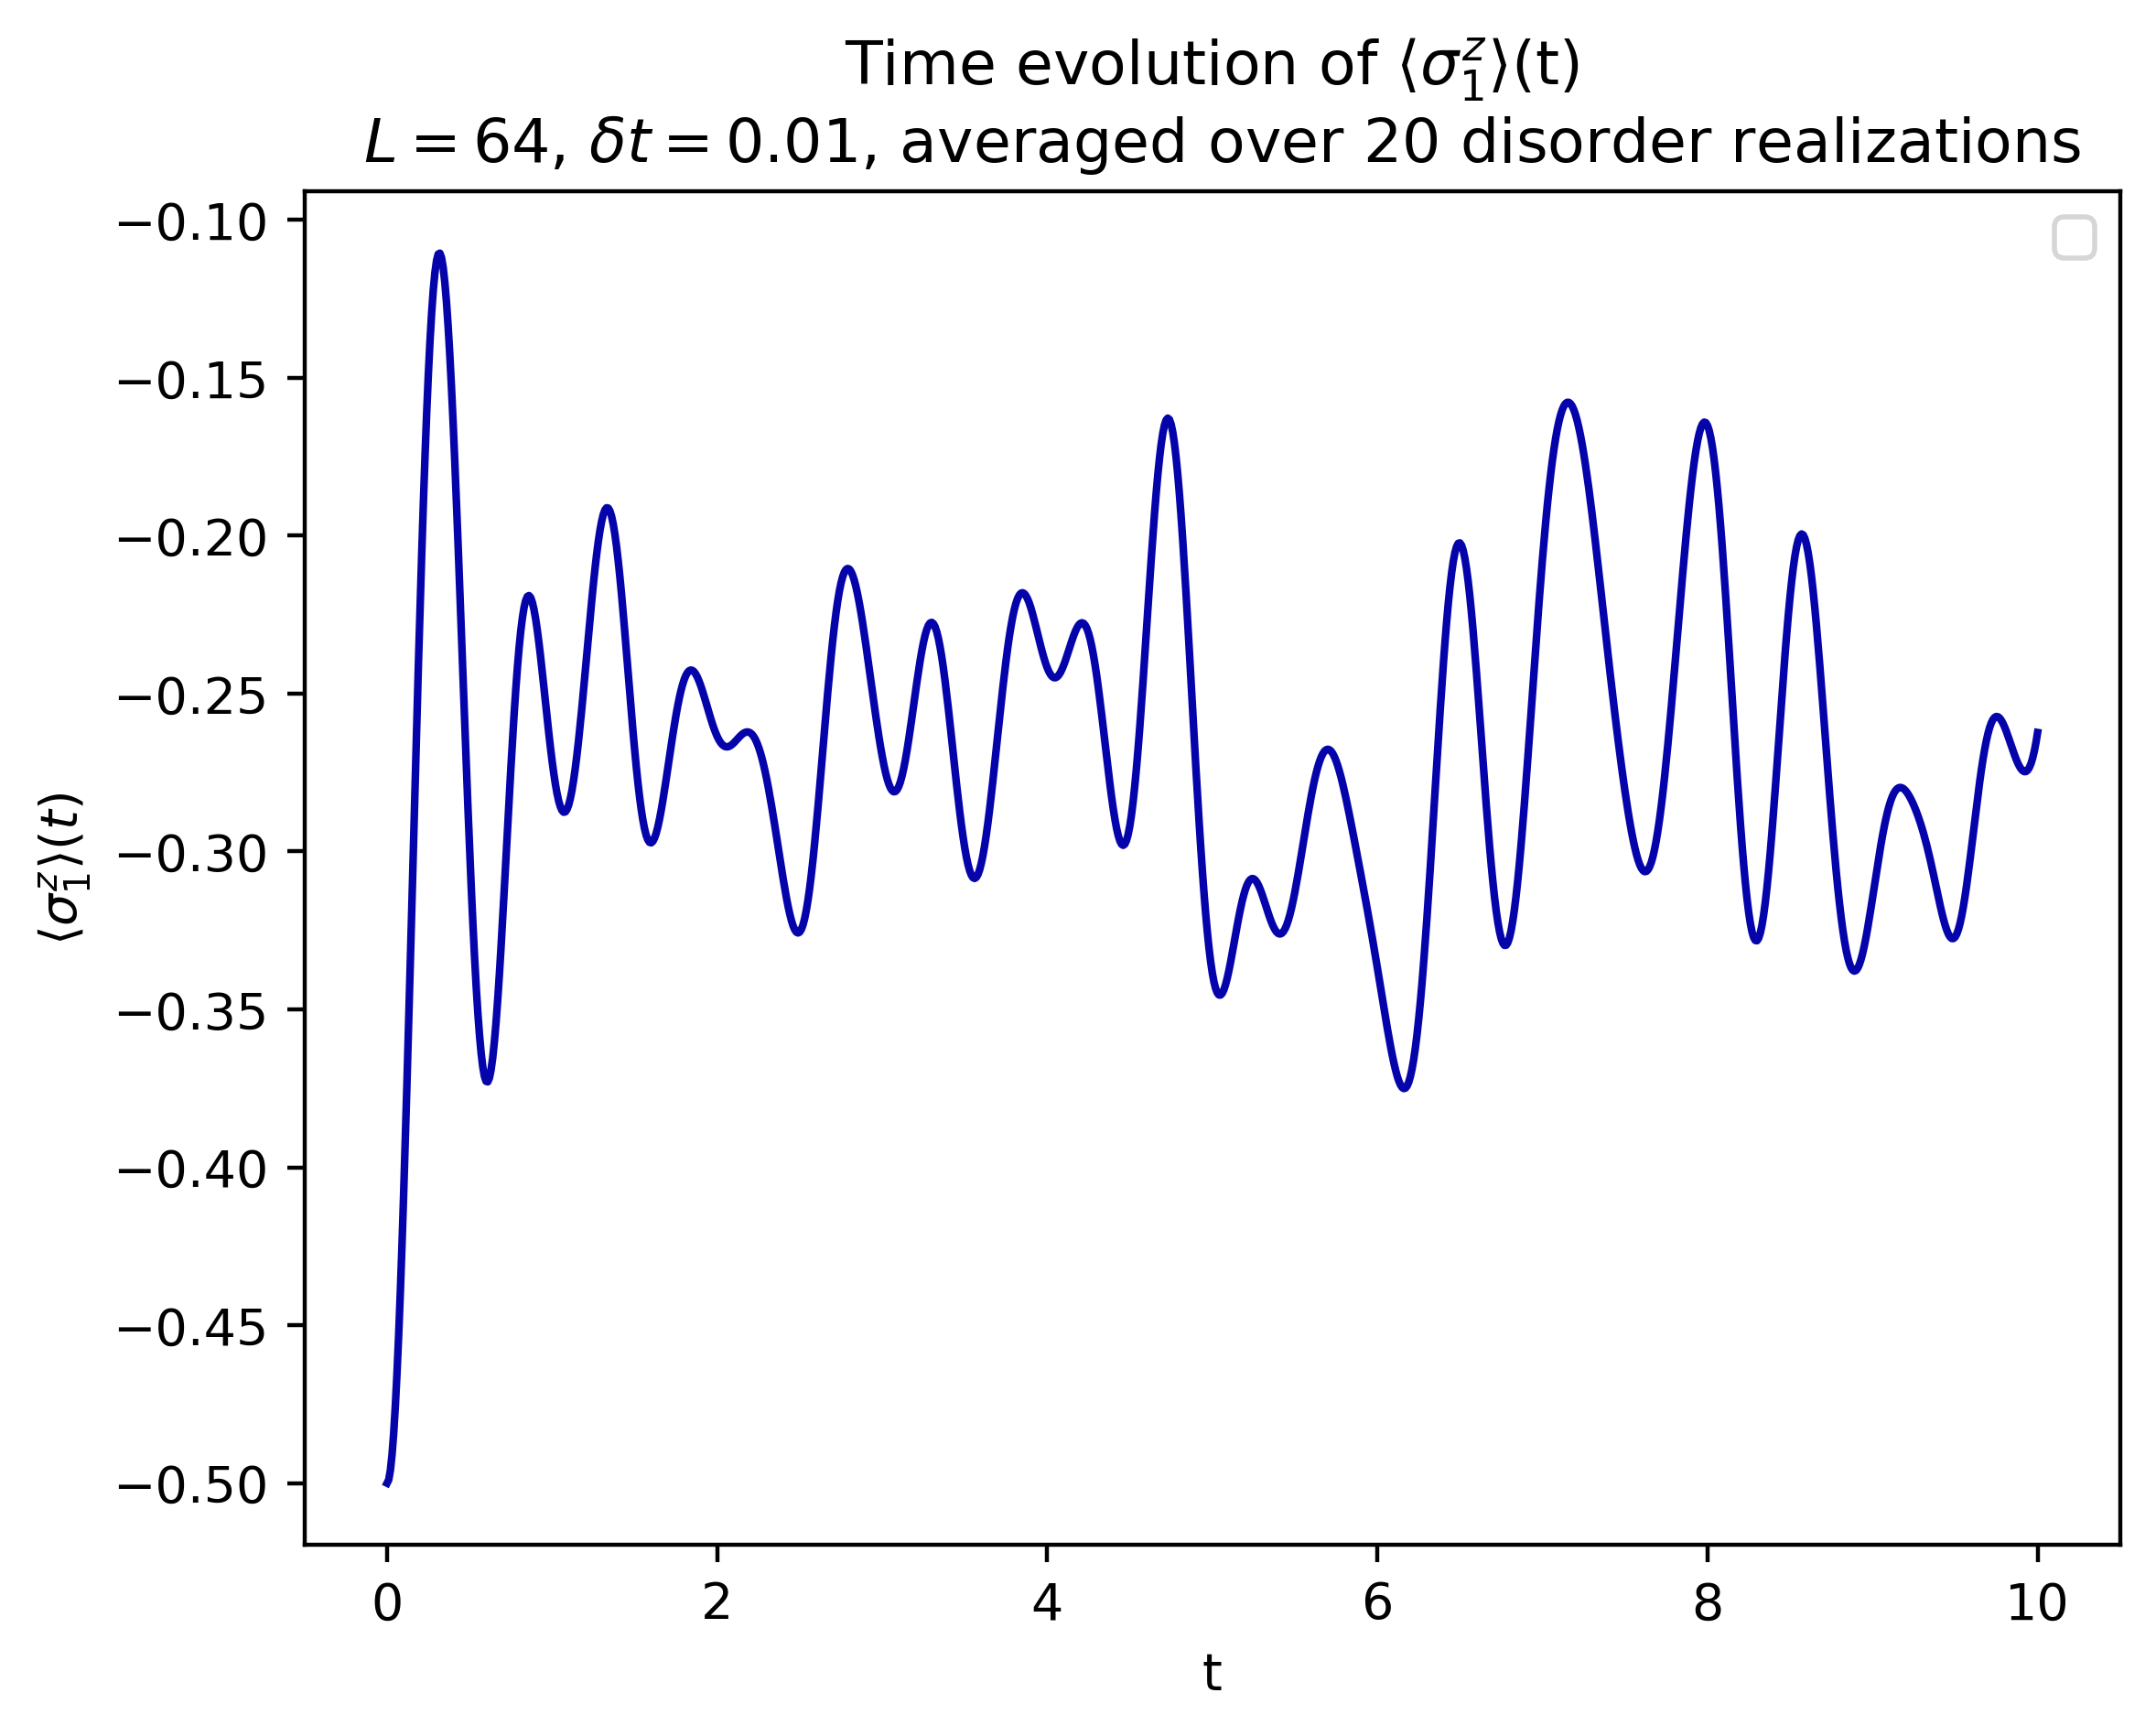

In [45]:
observables = []

for i in tqdm(range(len(canonical_trackerss[0])), desc="Computing Observables"):
    observable_realizations = []
    for j in range(20):
        observable = expectation_value_Cz(1, canonical_trackerss[j][i])
        observable_realizations.append(observable)
    
    observables.append(np.mean(observable_realizations))


plt.plot(np.arange(0, len(canonical_trackerss[0]), 1)*dt, observables, color='xkcd:royal blue')  

         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{1}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{1}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$, averaged over 20 disorder realizations')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazp3.png'), dpi=400)
plt.show()

Computing Observables: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:35<00:00, 28.04it/s]
2024-06-05 06:33:23,549 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


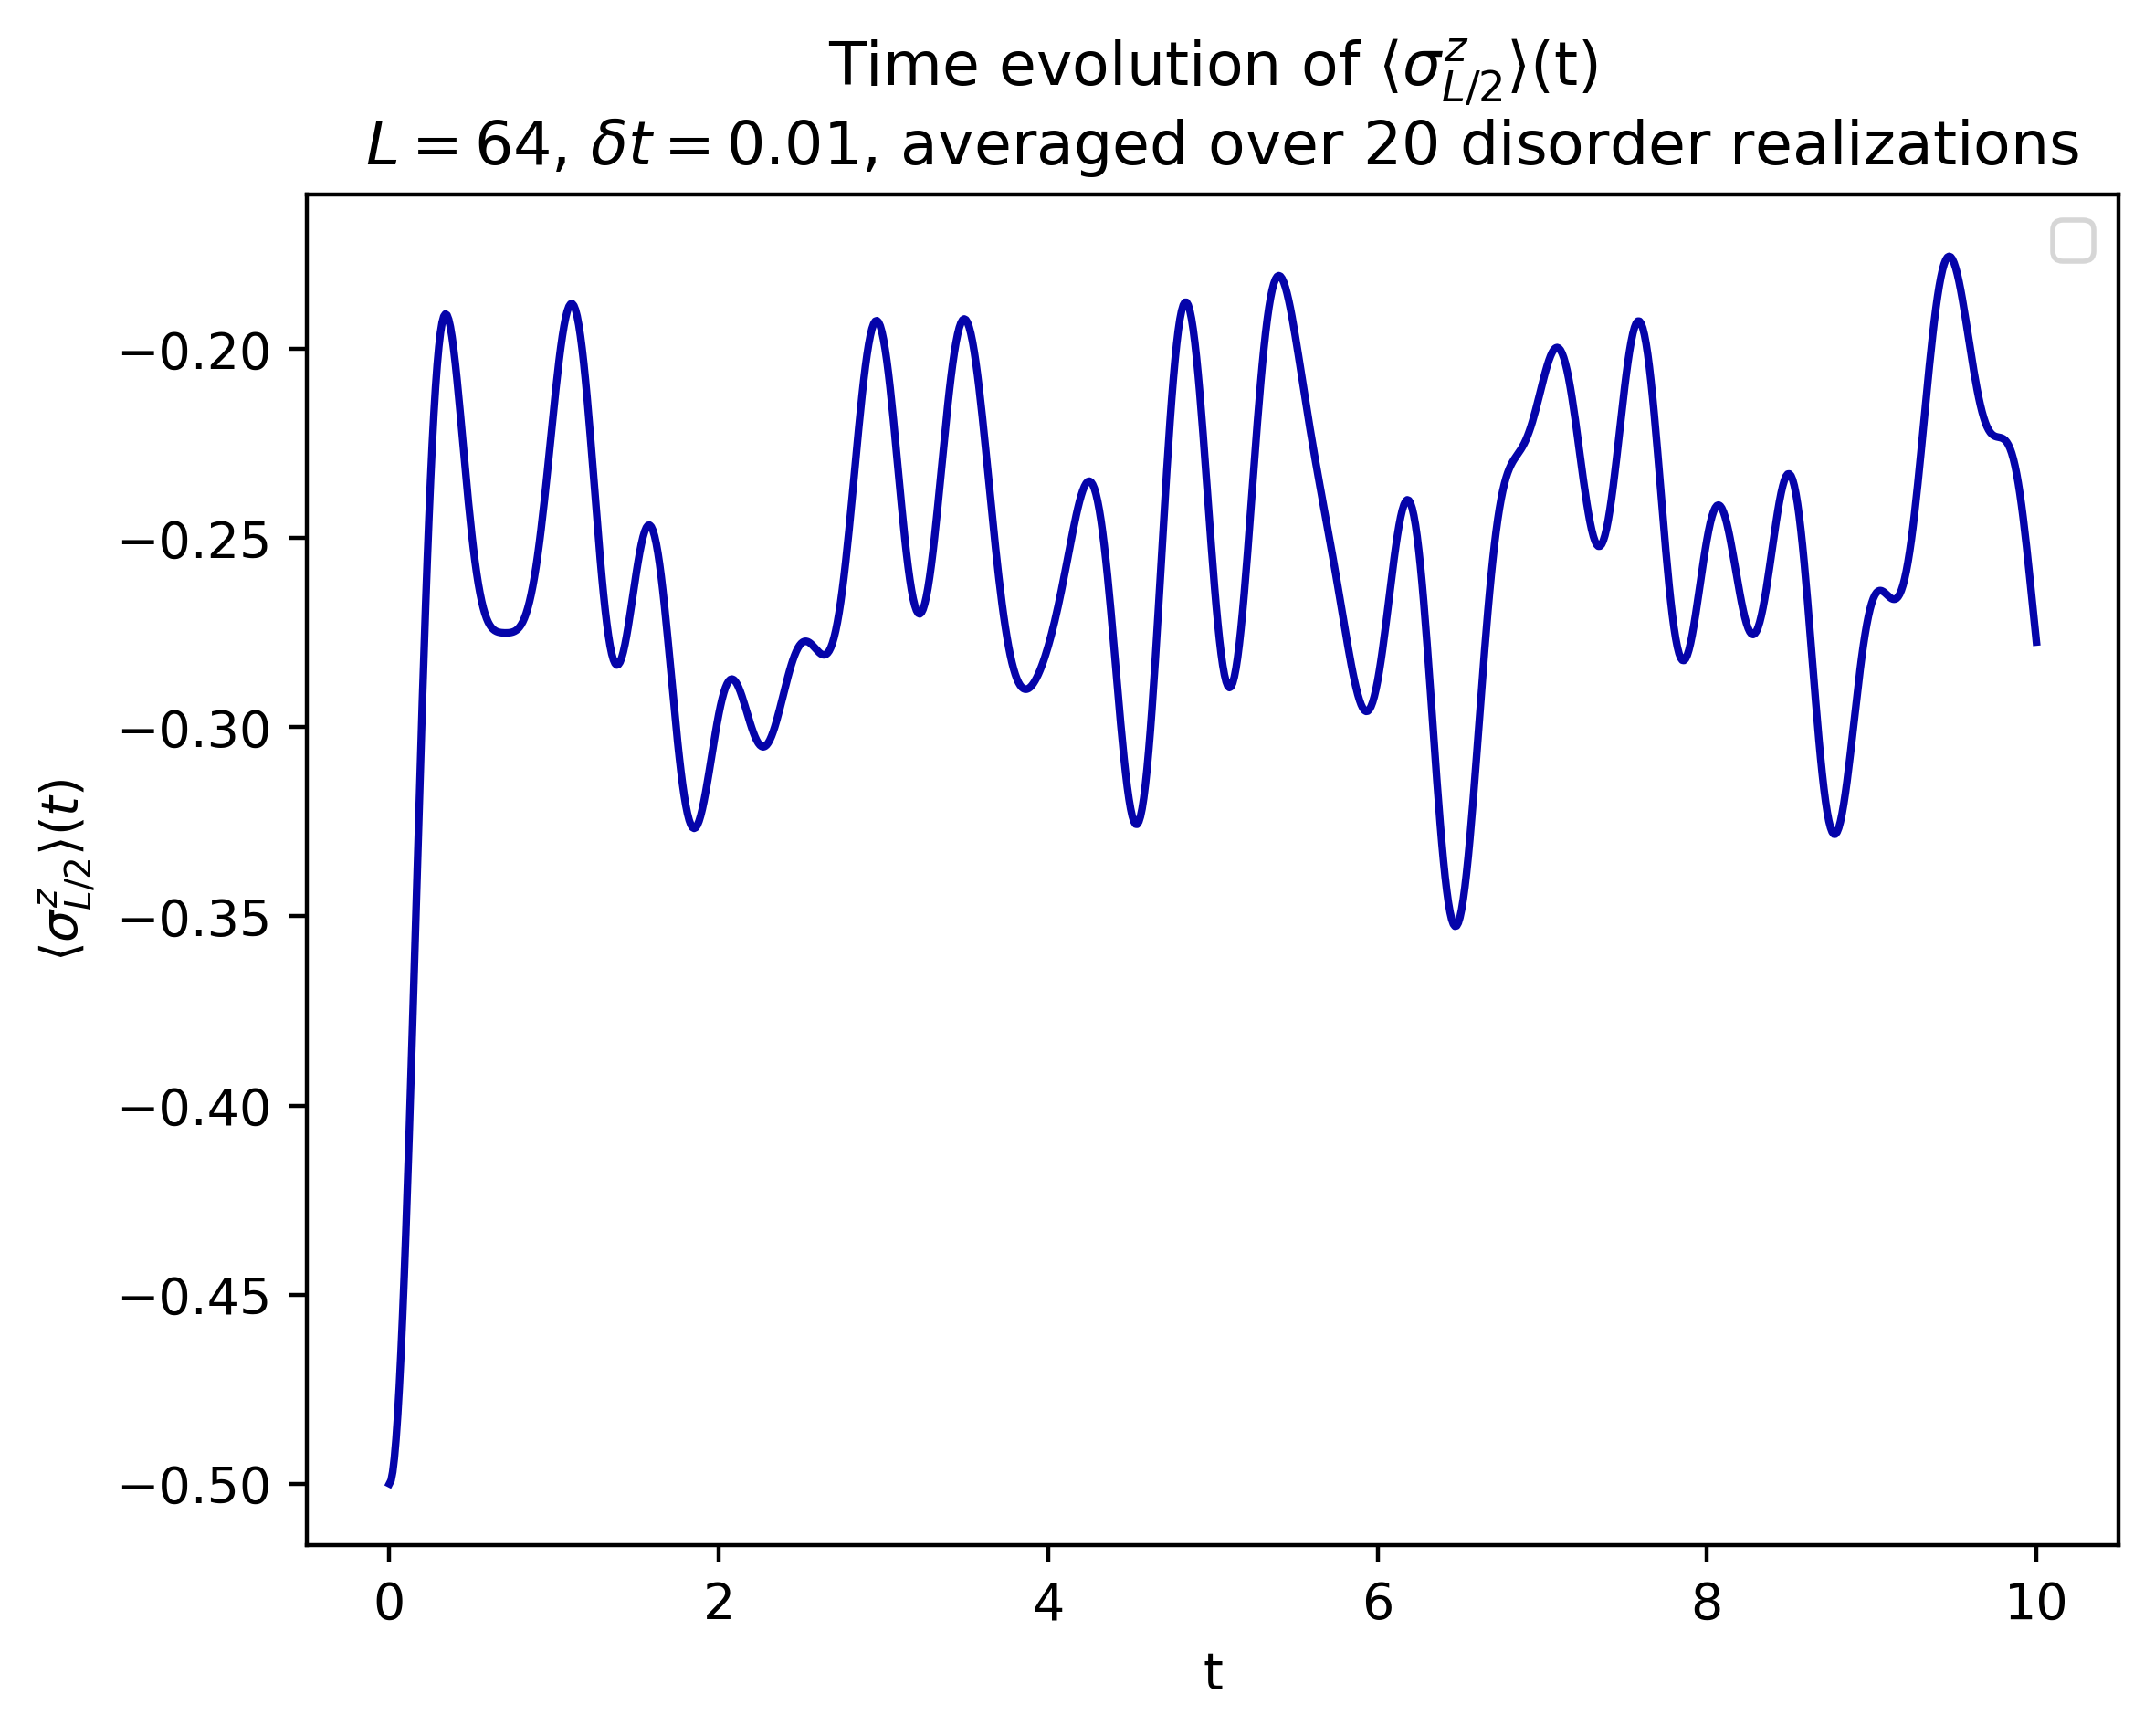

In [46]:
observables = []

for i in tqdm(range(len(canonical_trackerss[0])), desc="Computing Observables"):
    observable_realizations = []
    for j in range(20):
        observable = expectation_value_Cz(L//2, canonical_trackerss[j][i])
        observable_realizations.append(observable)
    
    observables.append(np.mean(observable_realizations))


plt.plot(np.arange(0, len(canonical_trackerss[0]), 1)*dt, observables, color='xkcd:royal blue')  

         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{L/2}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$, averaged over 20 disorder realizations')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazp3middle.png'), dpi=400)
plt.show()